In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from keras.utils.vis_utils import plot_model
from keras import Model
%matplotlib inline

C:\Users\p\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
import pandas as pd
import gzip

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('data/reviews_Musical_Instruments_5.gz')

- 리뷰아이디, 상품코드, 리뷰텍스트, 타겟은 오버롤, 세션을만들기 위해 순서가 필요함(유닉스리뷰타임)

In [7]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1392940800,"02 21, 2014"


- null값이 있으면 float로 들어온다.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10261 entries, 0 to 10260
Data columns (total 9 columns):
reviewerID        10261 non-null object
asin              10261 non-null object
reviewerName      10234 non-null object
helpful           10261 non-null object
reviewText        10261 non-null object
overall           10261 non-null float64
summary           10261 non-null object
unixReviewTime    10261 non-null int64
reviewTime        10261 non-null object
dtypes: float64(1), int64(1), object(7)
memory usage: 801.6+ KB


In [13]:
df = df[['reviewerID','asin','overall', 'reviewText', 'unixReviewTime']]
df = df.dropna()
df.overall = df.overall.astype(int)
df.reviewText = df.reviewText.str.lower()
df.reviewerID = df.reviewerID.astype('category').cat.codes.values
df.asin = df.asin.astype('category').cat.codes.values
df = df.sort_values(['reviewerID','unixReviewTime']).reset_index(drop=True)

In [16]:
df.head()

,reviewerID,asin,overall,reviewText,unixReviewTime
0,0,285,5,i ordered with my new guitar. these straps are...,1353024000
1,0,296,5,a friend of my has one and i just found in lov...,1353024000
2,0,419,5,"i bought this cable, because my guitar connect...",1353024000
3,0,442,5,"i'm a new user, but seem to be a great product...",1353024000
4,0,519,5,"my guitar, just love it! this stand is exactly...",1353024000


# 1. Session-based Recommendation

In [20]:
seqs=[]
tars=[]
maxlen=0
for user in df.reviewerID.unique():
    i_list = df[df.reviewerID==user].asin.values
    tar = list(df[df.reviewerID==user].overall[1:].values)
    seq = []
    for i in range(1, len(i_list)):
        seq.append(i_list[:i+1])
    if len(seq) > maxlen:
        maxlen = len(seq)
    seqs.extend(seq)
    tars.extend(tar)

In [22]:
tars

[5,
 5,
 5,
 5,
 4,
 5,
 5,
 5,
 1,
 2,
 5,
 5,
 5,
 4,
 5,
 5,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 3,
 5,
 5,
 5,
 4,
 4,
 4,
 5,
 5,
 4,
 5,
 5,
 4,
 4,
 4,
 5,
 5,
 4,
 4,
 5,
 4,
 4,
 5,
 4,
 5,
 5,
 5,
 5,
 5,
 3,
 5,
 5,
 5,
 5,
 4,
 5,
 3,
 5,
 5,
 5,
 5,
 5,
 3,
 2,
 5,
 4,
 5,
 5,
 4,
 1,
 2,
 5,
 5,
 5,
 5,
 3,
 5,
 5,
 5,
 3,
 5,
 2,
 4,
 1,
 5,
 1,
 1,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 4,
 5,
 5,
 5,
 5,
 2,
 2,
 5,
 5,
 5,
 3,
 5,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 4,
 4,
 4,
 5,
 5,
 5,
 5,
 3,
 3,
 4,
 5,
 5,
 4,
 2,
 4,
 4,
 5,
 5,
 3,
 4,
 5,
 5,
 5,
 2,
 5,
 5,
 5,
 5,
 4,
 3,
 5,
 5,
 5,
 5,
 5,
 5,
 1,
 1,
 4,
 4,
 3,
 5,
 5,
 5,
 5,
 1,
 5,
 4,
 5,
 4,
 3,
 5,
 3,
 5,
 5,
 3,
 5,
 4,
 4,
 4,
 4,
 5,
 4,
 4,
 5,
 5,
 5,
 5,
 3,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 4,
 5,
 5,
 4,
 5,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 4,
 5,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,


In [21]:
seqs

[array([285, 296], dtype=int16),
 array([285, 296, 419], dtype=int16),
 array([285, 296, 419, 442], dtype=int16),
 array([285, 296, 419, 442, 519], dtype=int16),
 array([285, 296, 419, 442, 519, 178], dtype=int16),
 array([285, 296, 419, 442, 519, 178, 398], dtype=int16),
 array([285, 296, 419, 442, 519, 178, 398, 692], dtype=int16),
 array([405, 619], dtype=int16),
 array([405, 619, 723], dtype=int16),
 array([405, 619, 723, 756], dtype=int16),
 array([405, 619, 723, 756, 226], dtype=int16),
 array([405, 619, 723, 756, 226, 304], dtype=int16),
 array([ 31, 226], dtype=int16),
 array([ 31, 226, 567], dtype=int16),
 array([ 31, 226, 567, 706], dtype=int16),
 array([ 31, 226, 567, 706, 721], dtype=int16),
 array([ 31, 226, 567, 706, 721, 156], dtype=int16),
 array([ 25, 285], dtype=int16),
 array([ 25, 285, 320], dtype=int16),
 array([ 25, 285, 320, 519], dtype=int16),
 array([ 25, 285, 320, 519, 574], dtype=int16),
 array([109, 103], dtype=int16),
 array([109, 103, 295], dtype=int16),
 

In [23]:
from keras.preprocessing import sequence
seqs = sequence.pad_sequences(seqs)

In [24]:
seqs

array([[  0,   0,   0, ...,   0, 285, 296],
       [  0,   0,   0, ..., 285, 296, 419],
       [  0,   0,   0, ..., 296, 419, 442],
       ...,
       [  0,   0,   0, ..., 699, 728, 834],
       [  0,   0,   0, ..., 728, 834, 114],
       [  0,   0,   0, ..., 834, 114, 222]])

In [25]:
from keras.models import Sequential
from keras.layers import Embedding, GRU, Dense

In [26]:
item_size = df.asin.max()+1
embed_size = 100

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 42, 100)           90000     
_________________________________________________________________
gru_3 (GRU)                  (None, 42, 32)            12768     
_________________________________________________________________
gru_4 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 110,097
Trainable params: 110,097
Non-trainable params: 0
_________________________________________________________________


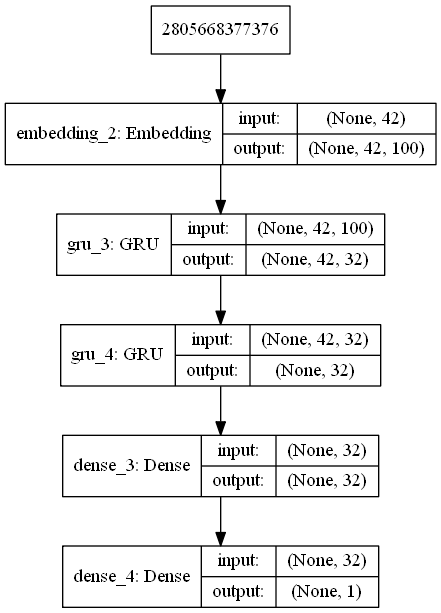

In [30]:
model = Sequential()
model.add(Embedding(item_size, embed_size, input_length=maxlen+1, mask_zero = True))
model.add(GRU(32, recurrent_dropout=0.2, return_sequences=True))
model.add(GRU(32, recurrent_dropout=0.2, return_sequences=False))
model.add(Dense(32))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mae"])
model.summary()
plot_model(model, to_file='model.png', show_shapes=True)
Image('model.png')

In [31]:
history = model.fit(seqs, np.asarray(tars), batch_size=256, epochs=30, validation_split=0.2)

Train on 7065 samples, validate on 1767 samples
Epoch 1/30
7065/7065 [==============================] - 7s 955us/step - loss: 13.8587 - mean_absolute_error: 3.4664 - val_loss: 3.8842 - val_mean_absolute_error: 1.6285
Epoch 2/30
7065/7065 [==============================] - 5s 675us/step - loss: 2.9093 - mean_absolute_error: 1.3641 - val_loss: 1.8797 - val_mean_absolute_error: 1.0694
Epoch 3/30
7065/7065 [==============================] - 5s 663us/step - loss: 1.4714 - mean_absolute_error: 0.9311 - val_loss: 1.4355 - val_mean_absolute_error: 0.9191
Epoch 4/30
7065/7065 [==============================] - 5s 669us/step - loss: 1.1060 - mean_absolute_error: 0.7949 - val_loss: 1.2405 - val_mean_absolute_error: 0.8474
Epoch 5/30
7065/7065 [==============================] - 5s 706us/step - loss: 0.9409 - mean_absolute_error: 0.7278 - val_loss: 1.1127 - val_mean_absolute_error: 0.7860
Epoch 6/30
7065/7065 [==============================] - 5s 677us/step - loss: 0.8549 - mean_absolute_error: 0.6

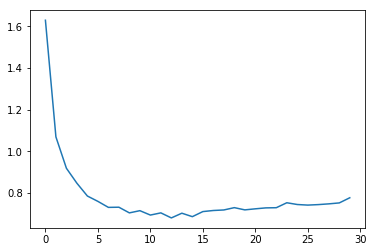

In [32]:
plt.plot(history.history['val_mean_absolute_error'])

# 2. Ask the GRU

In [33]:
max_features = 2000
embed_size = 100
n_items = len(df.asin.unique())
n_users = len(df.reviewerID.unique())

In [34]:
import collections
import os 
import nltk

maxlen = 0
word_freqs = collections.Counter()
num_recs = 0
for sentence in df.reviewText.values:
    words = nltk.word_tokenize(sentence)
    if len(words) > maxlen:
        maxlen = len(words)
    for word in words:
        word_freqs[word] += 1
    num_recs += 1

In [35]:
word2index = {x[0]: i+2 for i, x in enumerate(word_freqs.most_common(max_features))}
word2index["PAD"] = 0
word2index["UNK"] = 1
index2word = {v:k for k, v in word2index.items()}

In [36]:
x = np.empty((len(df),), dtype=list)
i=0

for review in df.reviewText.values:
    words = nltk.word_tokenize(review)
    seqs = []
    for word in words:
        if word in word2index:
            seqs.append(word2index[word])
        else:
            seqs.append(word2index["UNK"])
    x[i] = seqs
    i += 1
x = sequence.pad_sequences(x, maxlen=maxlen)

In [37]:
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Embedding, GRU, Add

In [38]:
x.shape

(10261, 2372)

In [39]:
maxlen

2372

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 2372)         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 2372, 100)    200200      input_1[0][0]                    
__________________________________________________________________________________________________
gru_5 (GRU)                     (None, 2372, 32)     12768       embedding_3[0][0]                
__________________________________________________________________________________________________
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
gru_6 (GRU

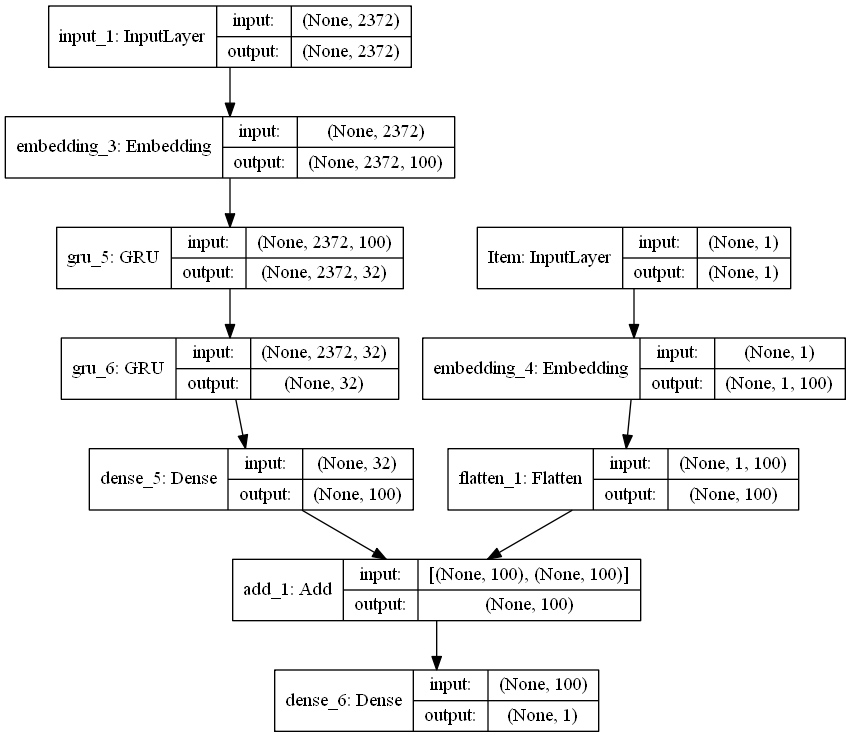

In [40]:
# GRU Layers
gru_in = Input(shape=(maxlen,))
gru_em = Embedding(max_features+2, embed_size, input_length=maxlen, mask_zero=True)(gru_in)
gru1 = GRU(32, recurrent_dropout=0.2, return_sequences=True)(gru_em)
gru2 = GRU(32, recurrent_dropout=0.2, return_sequences=False)(gru1)
g_func = Dense(embed_size)(gru2)

#item Layers
item_input = Input(shape=[1],name='Item')
item_embed = Embedding(n_items + 1, embed_size)(item_input)
item_vec = Flatten()(item_embed)

merge = Add()([g_func, item_vec])
out = Dense(1)(merge)

model = Model([gru_in, item_input], out)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["mae"])
model.summary()
plot_model(model, to_file='model.png', show_shapes=True)
Image('model.png')

In [42]:
history = model.fit([x, df.asin.values],df.overall.values, batch_size=256, epochs=30, validation_split=0.2)

Train on 8208 samples, validate on 2053 samples
Epoch 1/30
 256/8208 [..............................] - ETA: 29:29 - loss: 8.5035 - mean_absolute_error: 4.2747

KeyboardInterrupt: 

In [ ]:
plt.plot(history.history['val_mean_absolute_error'])